In [25]:
import maboss
import ginsim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
# Setup the name of the files
model_name =  'CRC_model_20231006'

# Visualizing the CRC model

In [27]:
crc_model = ginsim.load(model_name +'.zginml')
ginsim.show(crc_model)

# Load CRC model

We first define all inputs as 0.5 to activate all possible pathway, plus we defining the DNA damage at 0.5 to mimic the process of DNA damage cause by radio/chemotherapy

In [46]:
def load_model(init_node, init_val):
    if init_node == None:
        print('node not defined')
    ## Set up the required files
    bnd_file = model_name+".bnd"
    cfg_WT = model_name+".bnd.cfg"

    ## Load MaBoSS model
    WT = maboss.load(bnd_file, cfg_WT)

    ## modify the max_time if necessary
    ## select the variables considered to be internal (not appearing in the resulting csv file) 
    ## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
    WT_allinputs.update_parameters(sample_count = 1000)
    WT_allinputs.update_parameters(thread_count = 10)

    ## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
    ## If the model is big, the computations may take a very long time.
    ## We advise to set as external, only the variables that are relevant for the analysis

    ## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
    #for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
    for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
        WT_allinputs.network[name].is_internal = True

    ## Put all inputs at random
    for i in WT_allinputs.network.names:
        WT_allinputs.network.set_istate(i,[0.5,0.5])

    ## Set all inputs at 0.5
    WT_allinputs.network.set_istate('EGF',[0.5,0.5])
    WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
    WT_allinputs.network.set_istate('TNF',[0.5,0.5])
    WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
    WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
    WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
    WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])
    #WT_allinputs.network.set_istate('TOP2A',[1,0])
    #WT_allinputs.network.set_istate('CENPF',[1,0])
    #WT_allinputs.network.set_istate('MKi67',[1,0])
    WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])
    for i in range(len(init_node)):
        WT_allinputs.network.set_istate(init_node[i],[1-init_val[i],init_val[i]])

    ## Return key model
    return(WT_allinputs)

def mutate_models(gene_list, effect_list):
    # Select outputs for visualisation of the results
    WT_allinputs.network.set_output(('Proliferation','Apoptosis',
                                    'Replication_Catastrophe','Mitotic_Catastrophe',
                                    'DSB','SSB_RS'))
    model = {'WT':WT_allinputs}
    for i in range(len(gene_list)):
        x = maboss.copy_and_mutate(WT_allinputs, nodes = [gene_list[i]], mut = effect_list[i])
        model[gene_list[i]] = x

    key_model = model.keys()
    model_chek1={}
    for j in key_model:
        y = maboss.copy_and_mutate(model[j], nodes = ['CHEK1','CHEK2'], mut = 'OFF')
        model_chek1[j] = y

    key_model = model.keys()
    simulation = {}
    for k in key_model:
        simulation[k] = model[k].run()
    for k in key_model:
        simulation[k+'_chek1'] = model_chek1[k].run()
    return(simulation)

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


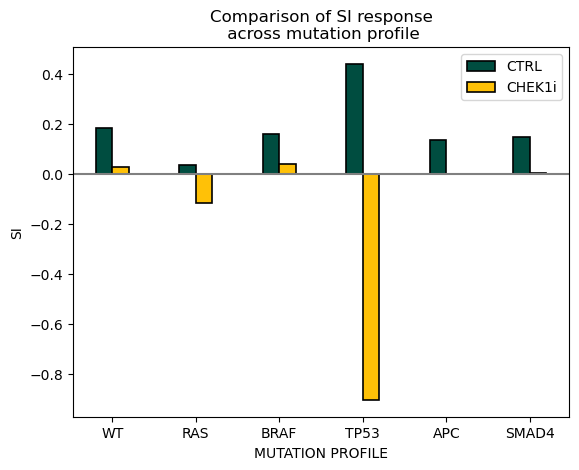

In [48]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DNA_damage_agent'], init_val=[0])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx = simulation_mtx.fillna(0)
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - (simulation_mtx['Replication_Catastrophe']+simulation_mtx['Mitotic_Catastrophe'])

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
#plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


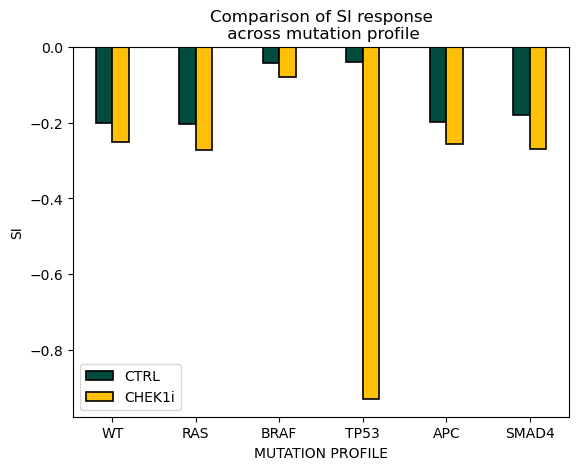

In [51]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DNA_damage_agent','TOP2A','CENPF','MKi67'], init_val=[0,0,0,0])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx = simulation_mtx.fillna(0)
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - (simulation_mtx['Apoptosis'])

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
#plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


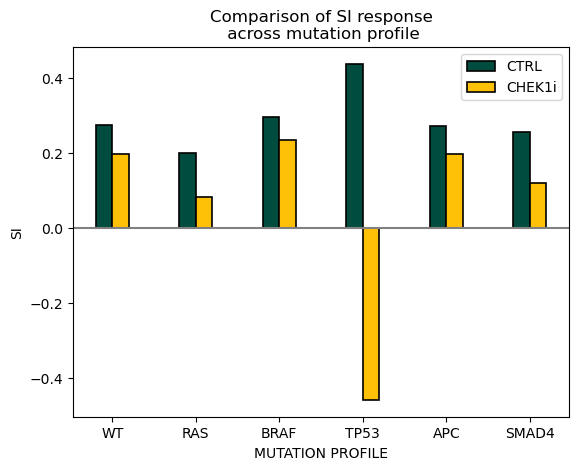

In [50]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DNA_damage_agent'], init_val=[0])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx = simulation_mtx.fillna(0)
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - (simulation_mtx['Apoptosis'])

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
#plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

In [54]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DNA_damage_agent','TOP2A','CENPF','MKi67'], init_val=[0,0.5,0.5,0.5])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx = simulation_mtx.fillna(0)
simulation_mtx['SI'] = simulation_mtx['Proliferation']
# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
#plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


KeyError: 'p21'

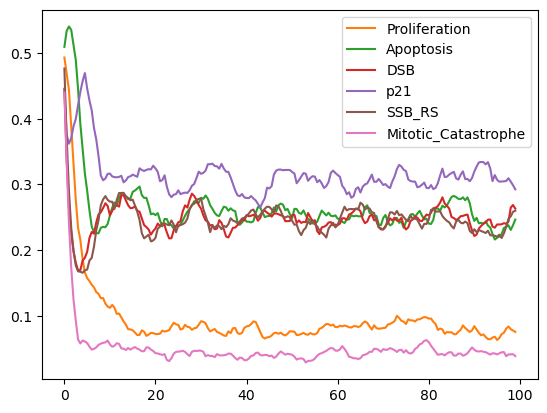

In [59]:
WT_allinputs = load_model(init_node = ['DNA_damage_agent','TOP2A','CENPF','MKi67'], init_val=[0,.5,0,.5])
WT_allinputs.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe','SSB_RS','DSB','p21'))
WT_allinputs.update_parameters(max_time = 100)
#WT_allinputs.mutate(node = 'GADD34',state = 'OFF')
#WT_allinputs.mutate(node = 'TP53',state = 'OFF')
#WT_allinputs.mutate(node = 'APC',state = 'ON')
#WT_allinputs.mutate(node = 'CHEK1',state = 'OFF')
#WT_allinputs.mutate(node = 'CHEK2',state = 'OFF')
test_result=WT_allinputs.run()
test_result.plot_node_trajectory()

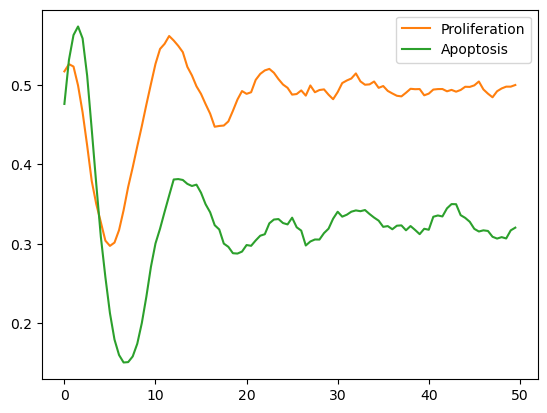

In [14]:
WT_allinputs = load_model(init_node = ['DNA_damage_agent','EGF','IFNA'], init_val=[0,])
WT_allinputs.network.set_output(('Proliferation','Apoptosis'))
#WT_allinputs.mutate(node = 'MK2',state = 'OFF')
WT_allinputs.mutate(node = 'BRAF',state = 'ON')
#WT_allinputs.mutate(node = 'APC',state = 'ON')
#WT_allinputs.mutate(node = 'CHEK1',state = 'OFF')
#WT_allinputs.mutate(node = 'CHEK2',state = 'OFF')
test_result=WT_allinputs.run()
test_result.plot_node_trajectory()

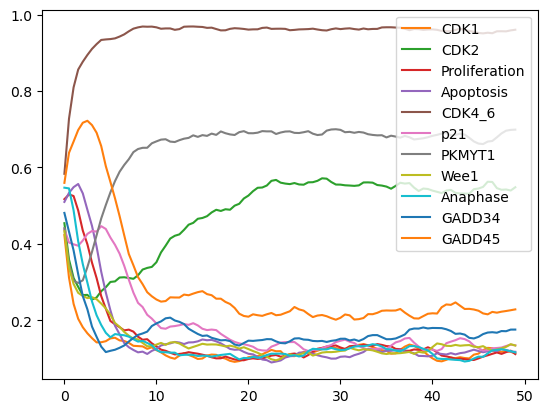

In [92]:
WT_allinputs = load_model(init_node = ['PLAU','DNA_damage_agent','EGF'], init_val=[0,0,0.5])
WT_allinputs.network.set_output(('Proliferation','Apoptosis',
                                 'CDK4_6','CDK2','CDK1','Anaphase',
                                 'p21','Wee1','PKMYT1',
                                 'GADD34','GADD45'))
#WT_allinputs.mutate(node = 'PYKMT1',state = 'OFF')
#WT_allinputs.mutate(node = 'TP53',state = 'OFF')
#WT_allinputs.mutate(node = 'APC',state = 'ON')
#WT_allinputs.mutate(node = 'CHEK1',state = 'OFF')
#WT_allinputs.mutate(node = 'CHEK2',state = 'OFF')
test_result=WT_allinputs.run()

test_result.plot_node_trajectory()

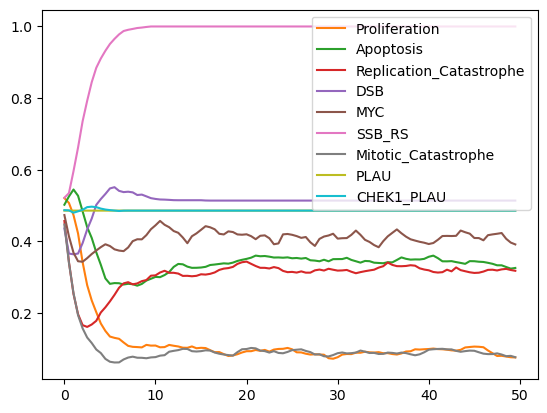

In [39]:
WT_allinputs = load_model(init_node = ['PLAU','DNA_damage_agent'], init_val=[0.5,1])
WT_allinputs.network.set_output(('Proliferation','Apoptosis',
                                    'Replication_Catastrophe','Mitotic_Catastrophe',
                                    'DSB','SSB_RS',
                                    'PLAU','CHEK1_PLAU',
                                    'MYC'))
WT_allinputs.mutate(node = 'TP53',state = 'OFF')
WT_allinputs.mutate(node = 'RAS',state = 'ON')
WT_allinputs.mutate(node = 'APC',state = 'ON')
WT_allinputs.mutate(node = 'CHEK1',state = 'OFF')
WT_allinputs.mutate(node = 'CHEK2',state = 'OFF')
test_result=WT_allinputs.run()

test_result.plot_node_trajectory()

In [40]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DYNLL1'], init_val=[0.5])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - simulation_mtx['Apoptosis']

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

KeyError: 'DYNLL1'

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


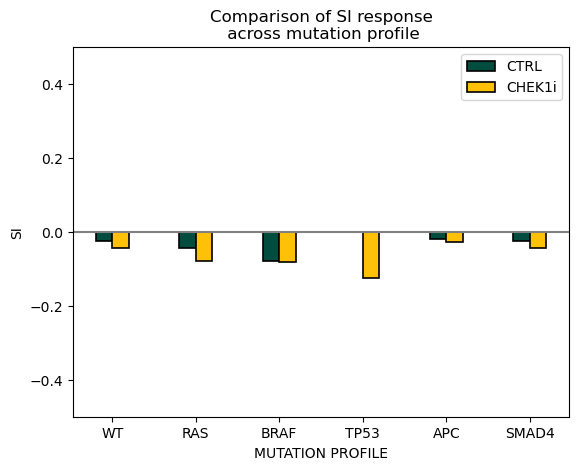

In [61]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['DNA_damage_agent','DYNLL1'], init_val=[1,0.5])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - simulation_mtx['Apoptosis']

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']


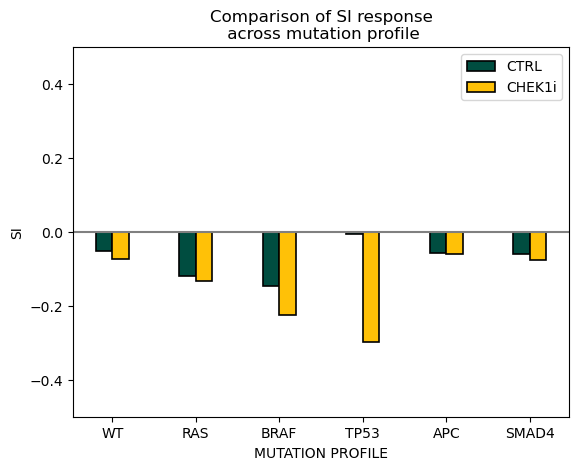

In [64]:
mutate_genes = ['RAS','BRAF','TP53','APC','SMAD4']
mutation_effect = ['ON','ON','OFF','OFF','OFF']
WT_allinputs = load_model(init_node = ['CDC20','DYNLL1'], init_val=[0,0])
model_simulation = mutate_models(gene_list= mutate_genes,
                                 effect_list=mutation_effect)

# Concatenate all data to matrix
model_list = list(model_simulation.keys())
simulation_mtx = pd.DataFrame()
for i in model_list:
    simulation_mtx = pd.concat([simulation_mtx,model_simulation[i].get_last_nodes_probtraj()],
                               ignore_index = False)
simulation_mtx.index = model_list
simulation_mtx['SI'] = simulation_mtx['Proliferation'] - simulation_mtx['Apoptosis']

# Plot data
X_axis = np.arange(len(model_list[0:6]))
plt.bar(X_axis - 0.1, list(simulation_mtx['SI'][0:6]), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(simulation_mtx['SI'][6:12]), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)
plt.xticks(X_axis, model_list[0:6])
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.5,0.5)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

## Simulation and visualizing the results
In this part, we set up the outputs of the model, run the simulation and visualizing nodes activity.

### Visualizing the  effect on key cell behavior
We visualize the evolution of key cell behaviors

- Proliferation + Apoptosis + Mitotic_Catastrophe
- DSB and SSB_RS

In [6]:
# Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Apoptosis',
                                 'Replication_Catastrophe','Mitotic_Catastrophe',
                                 'DSB','SSB_RS'))

# Define the condition
WT_KRAS = maboss.copy_and_mutate(WT_allinputs, nodes = ['RAS'], mut = 'ON')
WT_BRAF = maboss.copy_and_mutate(WT_allinputs, nodes = ['BRAF'], mut = 'ON')
WT_TP53 = maboss.copy_and_mutate(WT_allinputs, nodes = ['TP53'], mut = 'OFF')

# Run simulations
WT_res = WT_allinputs.run()
WT_KRAS_res = WT_KRAS.run()
WT_BRAF_res = WT_BRAF.run()
WT_TP53_res = WT_TP53.run()

# Mutate CHEK1
WT_allinputs_chek1 = maboss.copy_and_mutate(WT_allinputs, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_KRAS_chek1 = maboss.copy_and_mutate(WT_KRAS, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_BRAF_chek1 = maboss.copy_and_mutate(WT_BRAF, nodes = ['CHEK1','CHEK2'], mut= 'OFF')
WT_TP53_chek1 = maboss.copy_and_mutate(WT_TP53, nodes = ['CHEK1','CHEK2'], mut= 'OFF')

# Run simulations
WT_res_chek1 = WT_allinputs.run()
WT_KRAS_res_chek1 = WT_KRAS_chek1.run()
WT_BRAF_res_chek1 = WT_BRAF_chek1.run()
WT_TP53_res_chek1 = WT_TP53_chek1.run()

['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']


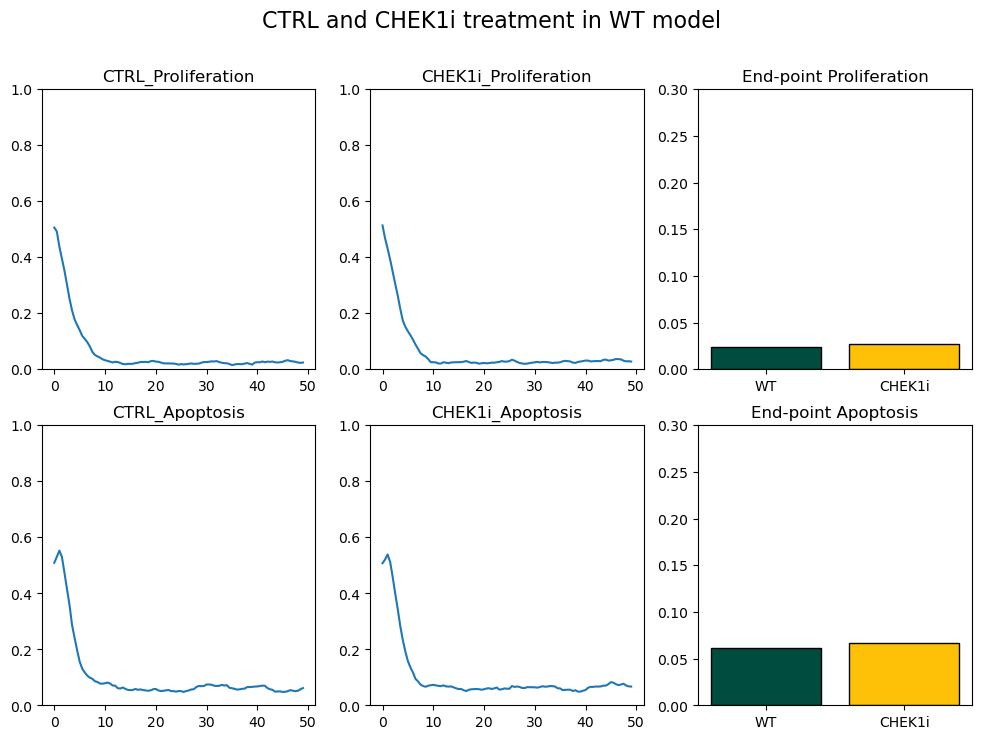

In [7]:
fig, axs = plt.subplots(ncols=3, nrows = 2, figsize=(12, 8))

axs[0][0].plot(WT_res.get_nodes_probtraj().Proliferation)
axs[0][0].set_ylim(0,1)
axs[0][0].title.set_text("CTRL_Proliferation")

axs[0][1].plot(WT_res_chek1.get_nodes_probtraj().Proliferation)
axs[0][1].set_ylim(0,1)
axs[0][1].title.set_text("CHEK1i_Proliferation")

axs[1][0].plot(WT_res.get_nodes_probtraj().Apoptosis)
axs[1][0].set_ylim(0,1)
axs[1][0].title.set_text("CTRL_Apoptosis")

axs[1][1].plot(WT_res_chek1.get_nodes_probtraj().Apoptosis)
axs[1][1].set_ylim(0,1)
axs[1][1].title.set_text("CHEK1i_Apoptosis")

treatment = ['WT','CHEK1i']
value = [WT_res.get_last_nodes_probtraj().Proliferation[0], 
         WT_res_chek1.get_last_nodes_probtraj().Proliferation[0]]
bar_colors = ['#004d40','#ffc107']
axs[0][2].bar(treatment, value, color = bar_colors, edgecolor = 'black')
axs[0][2].set_ylim(0,0.3)
axs[0][2].title.set_text("End-point Proliferation")

value = [WT_res.get_last_nodes_probtraj().Apoptosis[0], 
         WT_res_chek1.get_last_nodes_probtraj().Apoptosis[0]]
axs[1][2].bar(treatment, value, color = bar_colors, edgecolor = 'black')
axs[1][2].set_ylim(0,0.3)
axs[1][2].title.set_text("End-point Apoptosis")


fig.suptitle('CTRL and CHEK1i treatment in WT model', fontsize=16)
plt.show()

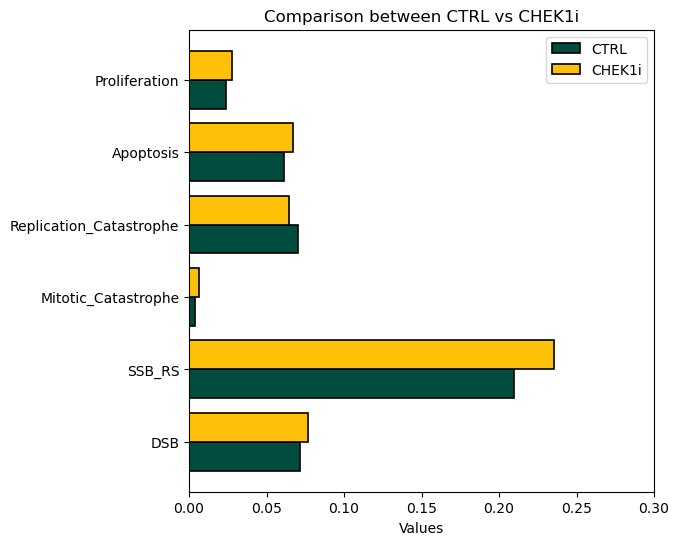

In [11]:
plt.figure(figsize=(6,6))

X = ['Proliferation','Apoptosis','Replication_Catastrophe','Mitotic_Catastrophe','SSB_RS','DSB']
X = ['DSB','SSB_RS','Mitotic_Catastrophe','Replication_Catastrophe','Apoptosis','Proliferation']
CTRL_data = list(WT_res.get_last_nodes_probtraj()[X].iloc[0,:])
CHEK1i_data = list(WT_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])

X_axis = np.arange(len(X))

plt.barh(X_axis - 0.2, CTRL_data, 0.4, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.barh(X_axis + 0.2, CHEK1i_data, 0.4, label = 'CHEK1i', color = '#ffc107', edgecolor = 'black', linewidth =1.2)
plt.yticks(X_axis, X)
plt.xlabel("Values")
#plt.ylabel("Simulation readouts")
plt.xlim(0,0.3)
plt.legend()
plt.title("Comparison between CTRL vs CHEK1i")

plt.show()

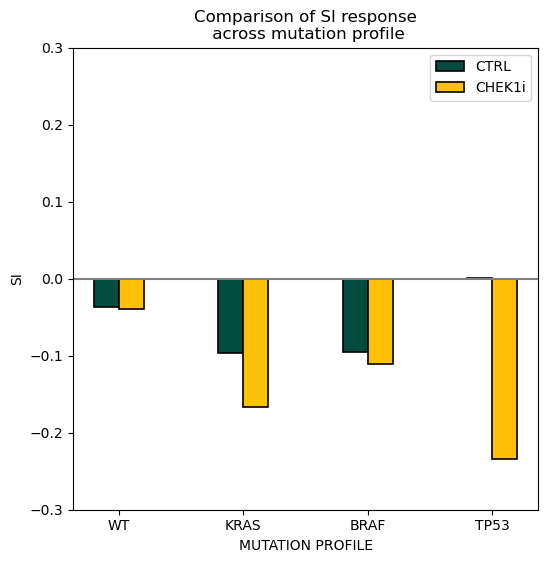

In [18]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = [WT_res, WT_KRAS_res,WT_BRAF_res,WT_TP53_res]
X_cheki = [WT_res_chek1, WT_KRAS_res_chek1,WT_BRAF_res_chek1,WT_TP53_res_chek1]
X_lab = ['WT','KRAS','BRAF','TP53']

# Get CTRL_data
CTRL_data = pd.DataFrame()
for i in X:
    CTRL_data = pd.concat([CTRL_data,i.get_last_nodes_probtraj()], ignore_index=False)
CTRL_data = CTRL_data.replace(np.nan,0)
CTRL_data.index = X_lab
CTRL_data['SI'] = CTRL_data['Proliferation'] - CTRL_data['Apoptosis']

# Get CHEK1i data
CHEK1i_data = pd.DataFrame()
for i in X_cheki:
    CHEK1i_data = pd.concat([CHEK1i_data,i.get_last_nodes_probtraj()], ignore_index=False)
CHEK1i_data = CHEK1i_data.replace(np.nan,0)
CHEK1i_data.index = X_lab
CHEK1i_data['SI'] = CHEK1i_data['Proliferation'] - CHEK1i_data['Apoptosis']

X_axis = np.arange(len(X_lab))

plt.bar(X_axis - 0.1, list(CTRL_data['SI']), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(CHEK1i_data['SI']), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)

plt.xticks(X_axis, X_lab)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.3,0.3)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']


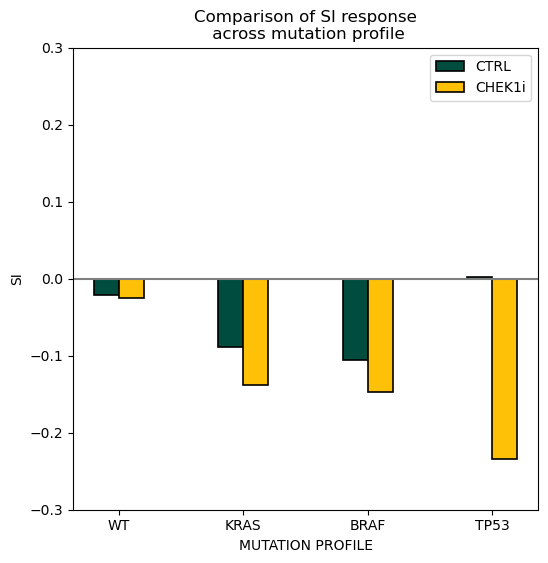

In [38]:
key_model = load_model(init_node='DYNLL1', init_val = 0)
sim_res = mutate_models()

# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = [sim_res['WT'], sim_res['KRAS'],sim_res['BRAF'],sim_res['TP53']]
X_cheki = [sim_res['chek1'],sim_res['chek1_KRAS'],sim_res['chek1_BRAF'],sim_res['chek1_TP53']]
X_lab = ['WT','KRAS','BRAF','TP53']

# Get CTRL_data
CTRL_data = pd.DataFrame()
for i in X:
    CTRL_data = pd.concat([CTRL_data,i.get_last_nodes_probtraj()], ignore_index=False)
CTRL_data = CTRL_data.replace(np.nan,0)
CTRL_data.index = X_lab
CTRL_data['SI'] = CTRL_data['Proliferation'] - CTRL_data['Apoptosis']

# Get CHEK1i data
CHEK1i_data = pd.DataFrame()
for i in X_cheki:
    CHEK1i_data = pd.concat([CHEK1i_data,i.get_last_nodes_probtraj()], ignore_index=False)
CHEK1i_data = CHEK1i_data.replace(np.nan,0)
CHEK1i_data.index = X_lab
CHEK1i_data['SI'] = CHEK1i_data['Proliferation'] - CHEK1i_data['Apoptosis']

X_axis = np.arange(len(X_lab))

plt.bar(X_axis - 0.1, list(CTRL_data['SI']), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(CHEK1i_data['SI']), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)

plt.xticks(X_axis, X_lab)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.3,0.3)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']


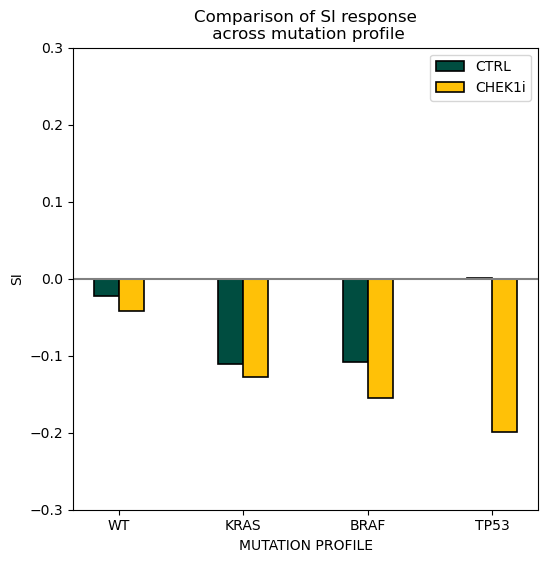

In [35]:
key_model = load_model(init_node='DYNLL1', init_val = 0.5)
sim_res = mutate_models()

# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = [sim_res['WT'], sim_res['KRAS'],sim_res['BRAF'],sim_res['TP53']]
X_cheki = [sim_res['chek1'],sim_res['chek1_KRAS'],sim_res['chek1_BRAF'],sim_res['chek1_TP53']]
X_lab = ['WT','KRAS','BRAF','TP53']

# Get CTRL_data
CTRL_data = pd.DataFrame()
for i in X:
    CTRL_data = pd.concat([CTRL_data,i.get_last_nodes_probtraj()], ignore_index=False)
CTRL_data = CTRL_data.replace(np.nan,0)
CTRL_data.index = X_lab
CTRL_data['SI'] = CTRL_data['Proliferation'] - CTRL_data['Apoptosis']

# Get CHEK1i data
CHEK1i_data = pd.DataFrame()
for i in X_cheki:
    CHEK1i_data = pd.concat([CHEK1i_data,i.get_last_nodes_probtraj()], ignore_index=False)
CHEK1i_data = CHEK1i_data.replace(np.nan,0)
CHEK1i_data.index = X_lab
CHEK1i_data['SI'] = CHEK1i_data['Proliferation'] - CHEK1i_data['Apoptosis']

X_axis = np.arange(len(X_lab))

plt.bar(X_axis - 0.1, list(CTRL_data['SI']), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(CHEK1i_data['SI']), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)

plt.xticks(X_axis, X_lab)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.3,0.3)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']
['BooleanNetwork exception: ', 'symbol $nb_mutable is not defined']


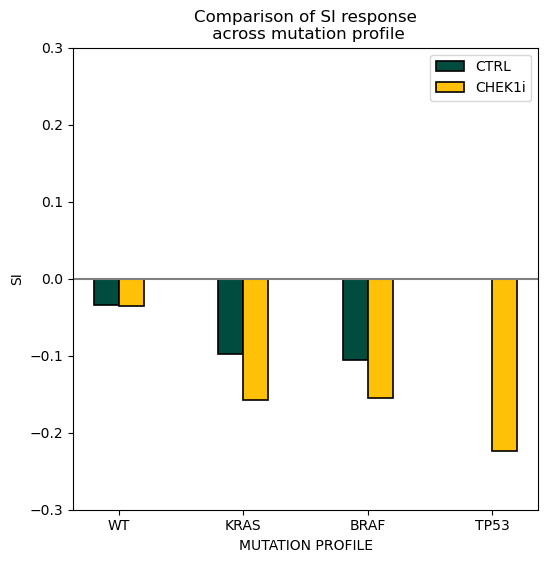

In [37]:
key_model = load_model(init_node='DYNLL1', init_val = 1)
sim_res = mutate_models()

# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = [sim_res['WT'], sim_res['KRAS'],sim_res['BRAF'],sim_res['TP53']]
X_cheki = [sim_res['chek1'],sim_res['chek1_KRAS'],sim_res['chek1_BRAF'],sim_res['chek1_TP53']]
X_lab = ['WT','KRAS','BRAF','TP53']

# Get CTRL_data
CTRL_data = pd.DataFrame()
for i in X:
    CTRL_data = pd.concat([CTRL_data,i.get_last_nodes_probtraj()], ignore_index=False)
CTRL_data = CTRL_data.replace(np.nan,0)
CTRL_data.index = X_lab
CTRL_data['SI'] = CTRL_data['Proliferation'] - CTRL_data['Apoptosis']

# Get CHEK1i data
CHEK1i_data = pd.DataFrame()
for i in X_cheki:
    CHEK1i_data = pd.concat([CHEK1i_data,i.get_last_nodes_probtraj()], ignore_index=False)
CHEK1i_data = CHEK1i_data.replace(np.nan,0)
CHEK1i_data.index = X_lab
CHEK1i_data['SI'] = CHEK1i_data['Proliferation'] - CHEK1i_data['Apoptosis']

X_axis = np.arange(len(X_lab))

plt.bar(X_axis - 0.1, list(CTRL_data['SI']), 0.2, label = 'CTRL',color = '#004d40', edgecolor = 'black', linewidth = 1.2)
plt.bar(X_axis + 0.1, list(CHEK1i_data['SI']), 0.2, label = 'CHEK1i',color = '#ffc107', edgecolor = 'black', linewidth = 1.2)

plt.xticks(X_axis, X_lab)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("SI")
plt.title("Comparison of SI response\n across mutation profile")
plt.ylim(-0.3,0.3)
plt.axhline(y=0,linewidth=1.5, color='grey')
plt.legend()
plt.show()

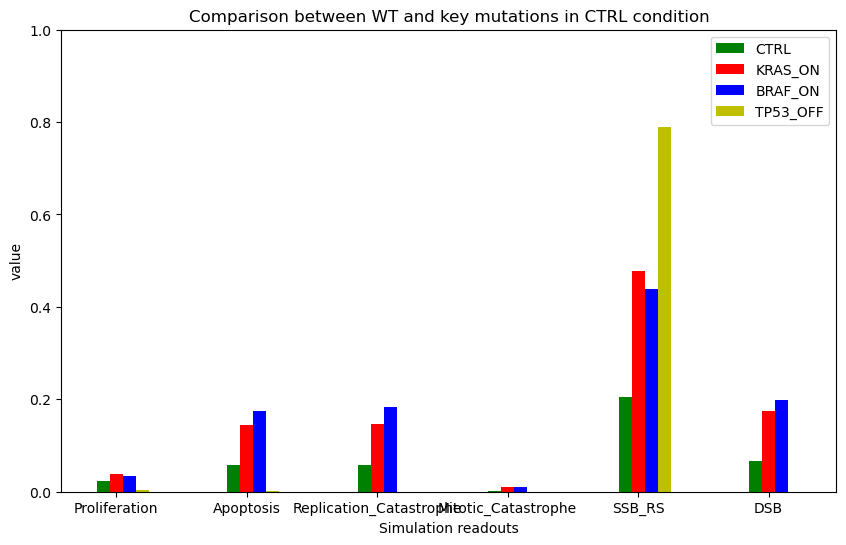

In [34]:
plt.figure(figsize=(10,6))

res_list = [WT_res, WT_KRAS_res, WT_BRAF_res, WT_TP53_res]
res_index = ['WT','KRAS','BRAF','TP53']
X = ['Proliferation','Apoptosis','Replication_Catastrophe','Mitotic_Catastrophe','SSB_RS','DSB']

# Concat Dataframe
res_data = pd.DataFrame()
for i in res_list:
    res_data = pd.concat([res_data, i.get_last_nodes_probtraj()], 
                         ignore_index=False)
    
# Adjust dataframe
res_data.index = res_index
res_data = res_data[X]
res_data = res_data.replace(np.nan,0)

# Plot
plt.bar(X_axis - 0.1, res_data.loc['WT',:], 0.1, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.0, res_data.loc['KRAS',:], 0.1, label = 'KRAS_ON', color = 'r')
plt.bar(X_axis + 0.1, res_data.loc['BRAF',:], 0.1, label = 'BRAF_ON', color = 'b')
plt.bar(X_axis + 0.2, res_data.loc['TP53',:], 0.1, label = 'TP53_OFF', color = 'y')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between WT and key mutations in CTRL condition")
plt.legend()
plt.show()

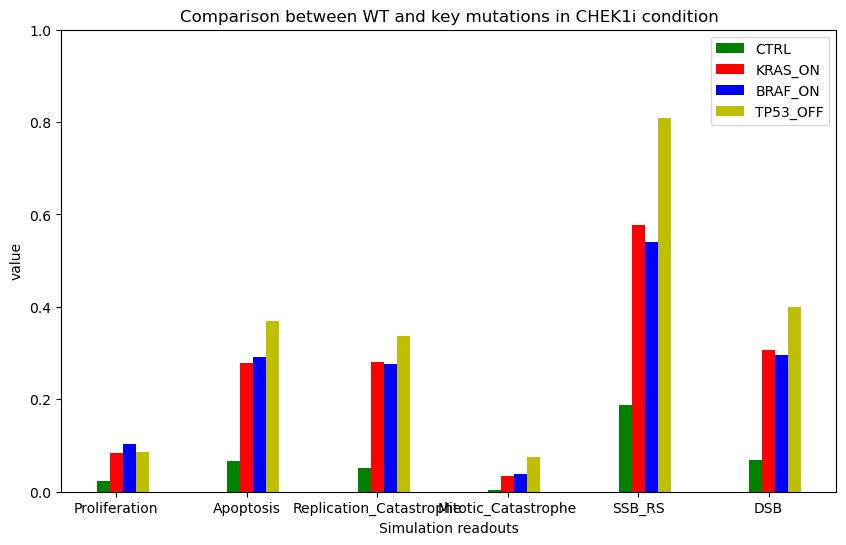

In [36]:
plt.figure(figsize=(10,6))

res_list = [WT_res_chek1, WT_KRAS_res_chek1, WT_BRAF_res_chek1, WT_TP53_res_chek1]
res_index = ['WT','KRAS','BRAF','TP53']
X = ['Proliferation','Apoptosis','Replication_Catastrophe','Mitotic_Catastrophe','SSB_RS','DSB']

# Concat Dataframe
res_data = pd.DataFrame()
for i in res_list:
    res_data = pd.concat([res_data, i.get_last_nodes_probtraj()], 
                         ignore_index=False)
    
# Adjust dataframe
res_data.index = res_index
res_data = res_data[X]
res_data = res_data.replace(np.nan,0)

# Plot
plt.bar(X_axis - 0.1, res_data.loc['WT',:], 0.1, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.0, res_data.loc['KRAS',:], 0.1, label = 'KRAS_ON', color = 'r')
plt.bar(X_axis + 0.1, res_data.loc['BRAF',:], 0.1, label = 'BRAF_ON', color = 'b')
plt.bar(X_axis + 0.2, res_data.loc['TP53',:], 0.1, label = 'TP53_OFF', color = 'y')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between WT and key mutations in CHEK1i condition")
plt.legend()
plt.show()

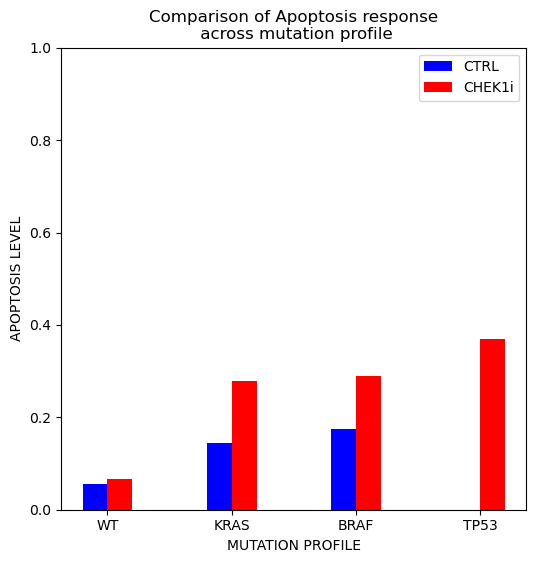

In [37]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = ['WT','KRAS','BRAF','TP53']

CTRL_data = [WT_res.get_last_nodes_probtraj().Apoptosis[0],
             WT_KRAS_res.get_last_nodes_probtraj().Apoptosis[0],
             WT_BRAF_res.get_last_nodes_probtraj().Apoptosis[0],
             WT_TP53_res.get_last_nodes_probtraj().Apoptosis[0]]

CHEK1i_data = [WT_res_chek1.get_last_nodes_probtraj().Apoptosis[0],
               WT_KRAS_res_chek1.get_last_nodes_probtraj().Apoptosis[0],
               WT_BRAF_res_chek1.get_last_nodes_probtraj().Apoptosis[0],
               WT_TP53_res_chek1.get_last_nodes_probtraj().Apoptosis[0]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.2, label = 'CTRL',color = 'b')
plt.bar(X_axis + 0.1, CHEK1i_data, 0.2, label = 'CHEK1i',color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("APOPTOSIS LEVEL")
plt.ylim(0,1)
plt.title("Comparison of Apoptosis response\n across mutation profile")
plt.legend()
plt.show()

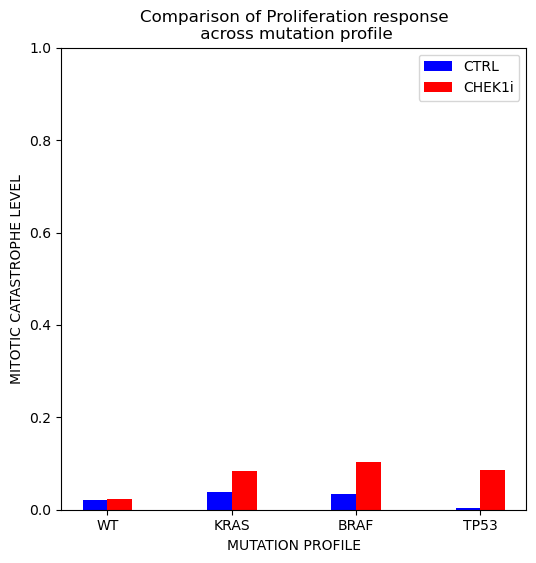

In [38]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = ['WT','KRAS','BRAF','TP53']

CTRL_data = [WT_res.get_last_nodes_probtraj().Proliferation[0],
             WT_KRAS_res.get_last_nodes_probtraj().Proliferation[0],
             WT_BRAF_res.get_last_nodes_probtraj().Proliferation[0],
             WT_TP53_res.get_last_nodes_probtraj().Proliferation[0]]

CHEK1i_data = [WT_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_KRAS_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_BRAF_res_chek1.get_last_nodes_probtraj().Proliferation[0],
               WT_TP53_res_chek1.get_last_nodes_probtraj().Proliferation[0]]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.2, label = 'CTRL',color = 'b')
plt.bar(X_axis + 0.1, CHEK1i_data, 0.2, label = 'CHEK1i',color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("MITOTIC CATASTROPHE LEVEL")
plt.ylim(0,1)
plt.title("Comparison of Proliferation response\n across mutation profile")
plt.legend()
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

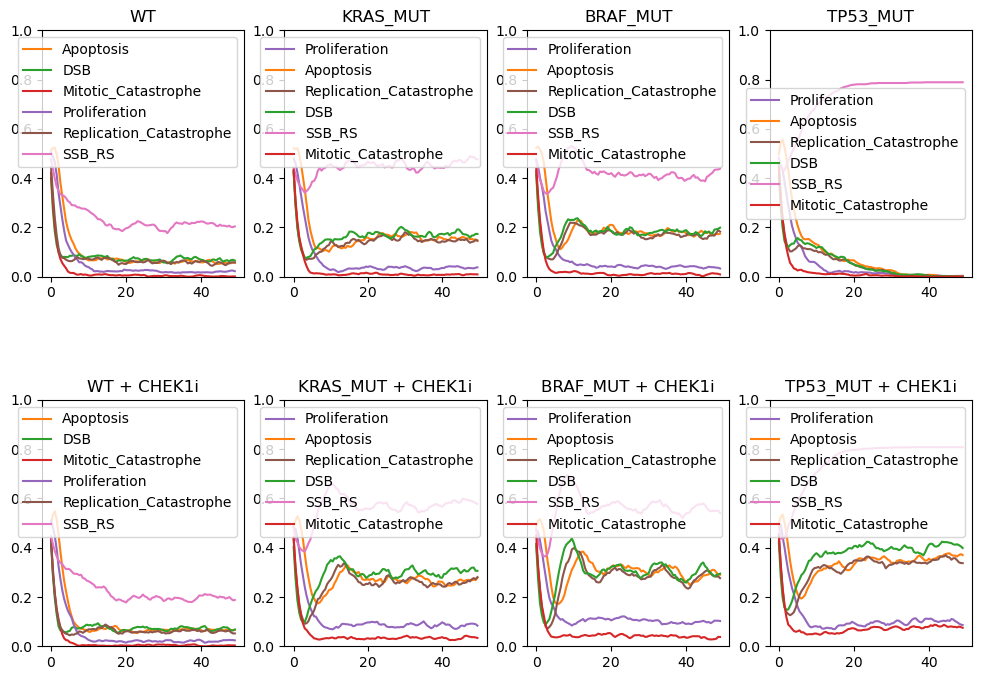

In [39]:
# Create plots

# Set up the axes with gridspec
import matplotlib.pyplot as plt

## define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)

# Plot WT
WT_res.plot_node_trajectory(axes = axs.ravel()[0])
axs[0][0].title.set_text("WT")
axs[0][0].set_ylim(0,1)

WT_KRAS_res.plot_node_trajectory(axes = axs.ravel()[1])
axs[0][1].title.set_text("KRAS_MUT")
axs[0][1].set_ylim(0,1)

WT_BRAF_res.plot_node_trajectory(axes = axs.ravel()[2])
axs[0][2].title.set_text("BRAF_MUT")
axs[0][2].set_ylim(0,1)

WT_TP53_res.plot_node_trajectory(axes = axs.ravel()[3])
axs[0][3].title.set_text("TP53_MUT")
axs[0][3].set_ylim(0,1)

# Plot CHEK1i
WT_res_chek1.plot_node_trajectory(axes = axs.ravel()[4])
axs[1][0].title.set_text("WT + CHEK1i")
axs[1][0].set_ylim(0,1)

WT_KRAS_res_chek1.plot_node_trajectory(axes = axs.ravel()[5])
axs[1][1].title.set_text("KRAS_MUT + CHEK1i")
axs[1][1].set_ylim(0,1)

WT_BRAF_res_chek1.plot_node_trajectory(axes = axs.ravel()[6])
axs[1][2].title.set_text("BRAF_MUT + CHEK1i")
axs[1][2].set_ylim(0,1)

WT_TP53_res_chek1.plot_node_trajectory(axes = axs.ravel()[7])
axs[1][3].title.set_text("TP53_MUT + CHEK1i")
axs[1][3].set_ylim(0,1)

plt.show()

In [130]:
## Set up the required files
bnd_file = model_name+".bnd"
cfg_WT = model_name+".bnd.cfg"

## Load MaBoSS model
WT = maboss.load(bnd_file, cfg_WT)

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
WT_allinputs.update_parameters(sample_count = 1000,
                               thread_count = 10)

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
#for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
     WT_allinputs.network[name].is_internal = True


## Put all inputs at random
for i in WT_allinputs.network.names:
    WT_allinputs.network.set_istate(i,[0.5,0.5])

## Set all inputs at 0.5
WT_allinputs.network.set_istate('EGF',[0.5,0.5])
WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
WT_allinputs.network.set_istate('TNF',[0.5,0.5])
WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])

####WT_allinputs.network.set_istate('GSK3B',[1,0])

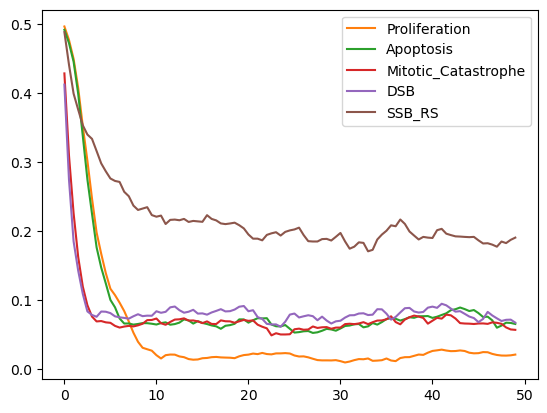

In [15]:
# Select outputs for visualisation of the results
WT_allinputs.network.set_output(('Proliferation','Apoptosis','Mitotic_Catastrophe',
                                 'DSB','SSB_RS'))

res = WT_allinputs.run()
res.plot_node_trajectory()

# Figure 1 : Model analysis

##  Figure 1A : First line model analysis

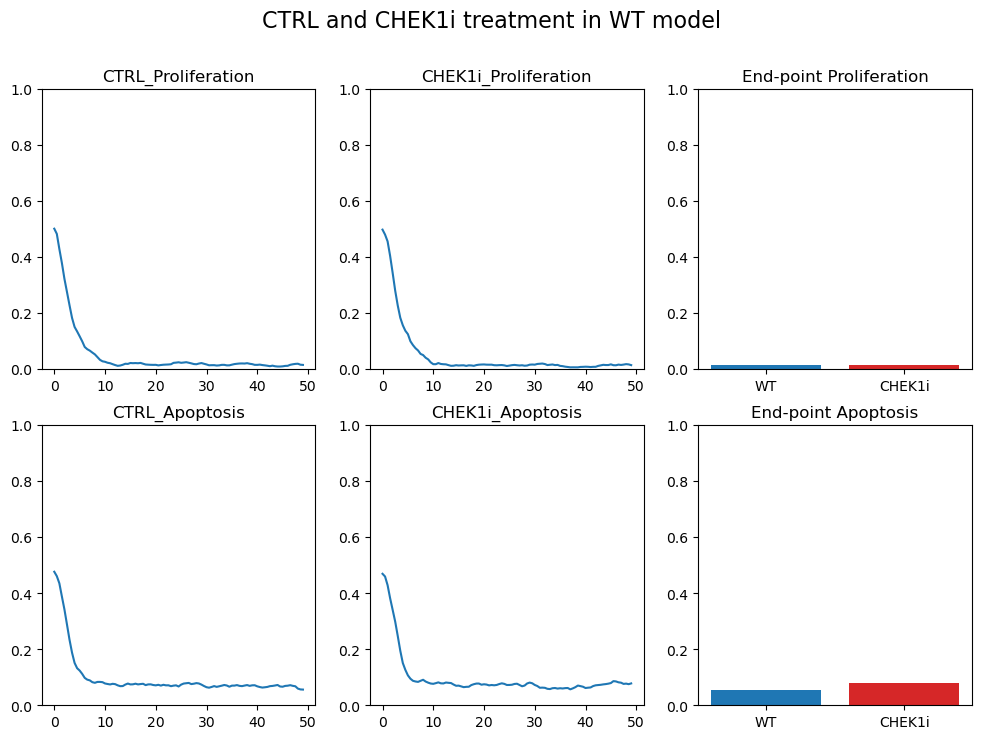

In [6]:
fig, axs = plt.subplots(ncols=3, nrows = 2, figsize=(12, 8))

axs[0][0].plot(WT_res.get_nodes_probtraj().Proliferation)
axs[0][0].set_ylim(0,1)
axs[0][0].title.set_text("CTRL_Proliferation")

axs[0][1].plot(WT_res_chek1.get_nodes_probtraj().Proliferation)
axs[0][1].set_ylim(0,1)
axs[0][1].title.set_text("CHEK1i_Proliferation")

axs[1][0].plot(WT_res.get_nodes_probtraj().Apoptosis)
axs[1][0].set_ylim(0,1)
axs[1][0].title.set_text("CTRL_Apoptosis")

axs[1][1].plot(WT_res_chek1.get_nodes_probtraj().Apoptosis)
axs[1][1].set_ylim(0,1)
axs[1][1].title.set_text("CHEK1i_Apoptosis")

treatment = ['WT','CHEK1i']
value = [WT_res.get_last_nodes_probtraj().Proliferation[0], 
         WT_res_chek1.get_last_nodes_probtraj().Proliferation[0]]
bar_colors = ['tab:blue','tab:red']
axs[0][2].bar(treatment, value, color = bar_colors)
axs[0][2].set_ylim(0,1)
axs[0][2].title.set_text("End-point Proliferation")

value = [WT_res.get_last_nodes_probtraj().Apoptosis[0], 
         WT_res_chek1.get_last_nodes_probtraj().Apoptosis[0]]
axs[1][2].bar(treatment, value, color = bar_colors)
axs[1][2].set_ylim(0,1)
axs[1][2].title.set_text("End-point Apoptosis")


fig.suptitle('CTRL and CHEK1i treatment in WT model', fontsize=16)
plt.show()

## Figure 1B : Introducing the effect of CHEK1i to the model

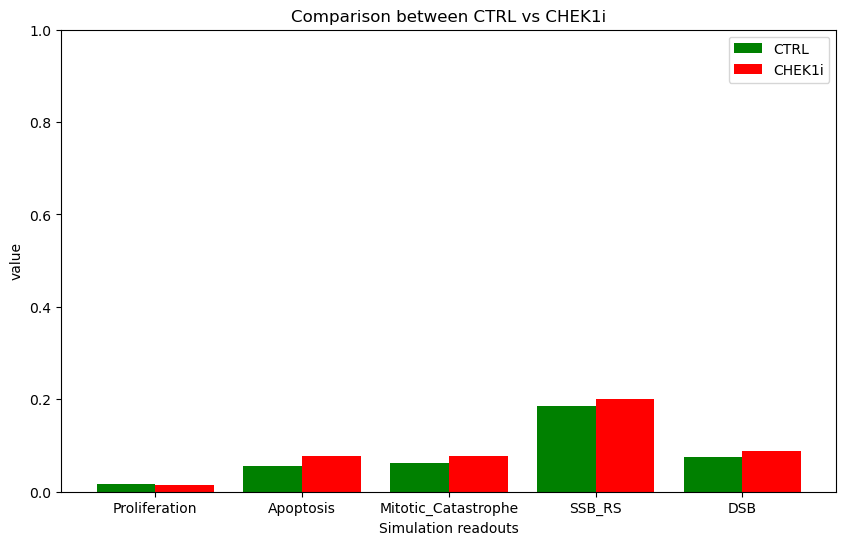

In [7]:
plt.figure(figsize=(10,6))

X = ['Proliferation','Apoptosis','Mitotic_Catastrophe','SSB_RS','DSB']
CTRL_data = list(WT_res.get_last_nodes_probtraj()[X].iloc[0,:])
CHEK1i_data = list(WT_res_chek1.get_last_nodes_probtraj()[X].iloc[0,:])

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, CTRL_data, 0.4, label = 'CTRL',color = 'g')
plt.bar(X_axis + 0.2, CHEK1i_data, 0.4, label = 'CHEK1i', color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("Simulation readouts")
plt.ylabel("value")
plt.ylim(0,1)
plt.title("Comparison between CTRL vs CHEK1i")
plt.legend()
plt.show()


## Figure 1C: Introducing the effect of mutation to the model
In this part, we simulate several common mutation effect using our model.

The readout of the simulation is called --- `CHEKi_sensitivity` = `Apoptosis` - `Proliferation`

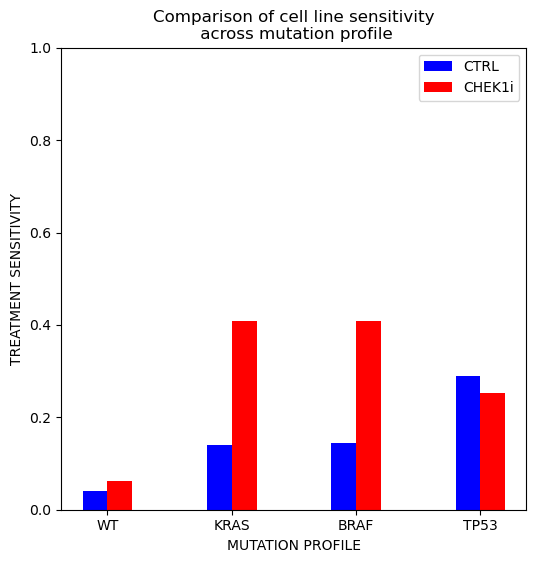

In [11]:
# MITOTIC CATSTROPHE IN ALL MUT PROFILE

plt.figure(figsize=(6,6))

X = ['WT','KRAS','BRAF','TP53']

CTRL_data = [(WT_res.get_last_nodes_probtraj().Apoptosis[0]-WT_res.get_last_nodes_probtraj().Proliferation[0]),
             (WT_KRAS_res.get_last_nodes_probtraj().Apoptosis[0]-WT_KRAS_res.get_last_nodes_probtraj().Proliferation[0]),
             (WT_BRAF_res.get_last_nodes_probtraj().Apoptosis[0]-WT_BRAF_res.get_last_nodes_probtraj().Proliferation[0]),
             (WT_TP53_res.get_last_nodes_probtraj().Apoptosis[0]-WT_TP53_res.get_last_nodes_probtraj().Proliferation[0])]

CHEK1i_data =[(WT_res_chek1.get_last_nodes_probtraj().Apoptosis[0]-WT_res_chek1.get_last_nodes_probtraj().Proliferation[0]),
             (WT_KRAS_res_chek1.get_last_nodes_probtraj().Apoptosis[0]-WT_KRAS_res_chek1.get_last_nodes_probtraj().Proliferation[0]),
             (WT_KRAS_res_chek1.get_last_nodes_probtraj().Apoptosis[0]-WT_KRAS_res_chek1.get_last_nodes_probtraj().Proliferation[0]),
             (WT_TP53_res_chek1.get_last_nodes_probtraj().Apoptosis[0]-WT_TP53_res_chek1.get_last_nodes_probtraj().Proliferation[0])]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, CTRL_data, 0.2, label = 'CTRL',color = 'b')
plt.bar(X_axis + 0.1, CHEK1i_data, 0.2, label = 'CHEK1i',color = 'r')

plt.xticks(X_axis, X)
plt.xlabel("MUTATION PROFILE")
plt.ylabel("TREATMENT SENSITIVITY")
plt.ylim(0,1)
plt.title("Comparison of cell line sensitivity\n across mutation profile")
plt.legend()
plt.show()



In [25]:
model_component = WT_allinputs.network.names.copy()

# Remove model inputs
model_component.remove('DNA_damage_agent')
model_component.remove('IFNA')
model_component.remove('EGF')
model_component.remove('TNF')
model_component.remove('TGFb')
model_component.remove('IL1R1')
model_component.remove('Wnt')

# Remove model outputs
model_component.remove('Proliferation')
model_component.remove('Apoptosis')
model_component.remove('Mitotic_Catastrophe')
model_component.remove('Anaphase')
model_component.remove('Protein_synthesis')
model_component.remove('SSB_RS')
model_component.remove('DSB')

In [67]:
# Mutate OFF
## Simulate Untreated condition
model = get_model(model_name)
model.network.set_output(('Proliferation','Apoptosis'))
WT_res = model.run()
sensitivity_off = WT_res.get_last_nodes_probtraj()
sensitivity_off.index = ['WT']
model_res={}
### For-loop simulation
for i in model_component:
    tmp_model = maboss.copy_and_mutate(model, nodes = [i], mut = 'OFF')
    model_res[i] = tmp_model.run()
    tmp_res = model_res[i].get_last_nodes_probtraj()
    tmp_res.index = [i]
    sensitivity_off = pd.concat([sensitivity_off, tmp_res], ignore_index = False)


## Simulate Treated condition
model = get_model(model_name)
model.mutate(node = 'CHEK1',state = 'OFF')
model.mutate(node = 'CHEK2',state = 'OFF')
model.network.set_output(('Proliferation','Apoptosis'))
WT_res = model.run()
cheki_off = WT_res.get_last_nodes_probtraj()
cheki_off.index = ['WT']
model_res={}
### For-loop simulation
for i in model_component:
    tmp_model = maboss.copy_and_mutate(model, nodes = [i], mut = 'OFF')
    model_res[i] = tmp_model.run()
    tmp_res = model_res[i].get_last_nodes_probtraj()
    tmp_res.index = [i]
    cheki_off = pd.concat([cheki_off, tmp_res], ignore_index = False)

# Mutate ON
## Simulate Untreated condition
model = get_model(model_name)
model.network.set_output(('Proliferation','Apoptosis'))
WT_res = model.run()
sensitivity_on = WT_res.get_last_nodes_probtraj()
sensitivity_on.index = ['WT']
model_res={}
### For-loop simulation
for i in model_component:
    tmp_model = maboss.copy_and_mutate(model, nodes = [i], mut = 'ON')
    model_res[i] = tmp_model.run()
    tmp_res = model_res[i].get_last_nodes_probtraj()
    tmp_res.index = [i]
    sensitivity_on = pd.concat([sensitivity_on, tmp_res], ignore_index = False)


## Simulate Treated condition
model = get_model(model_name)
model.mutate(node = 'CHEK1',state = 'OFF')
model.mutate(node = 'CHEK2',state = 'OFF')
model.network.set_output(('Proliferation','Apoptosis'))
WT_res = model.run()
cheki_on = WT_res.get_last_nodes_probtraj()
cheki_on.index = ['WT']
model_res={}
### For-loop simulation
for i in model_component:
    tmp_model = maboss.copy_and_mutate(model, nodes = [i], mut = 'ON')
    model_res[i] = tmp_model.run()
    tmp_res = model_res[i].get_last_nodes_probtraj()
    tmp_res.index = [i]
    cheki_on = pd.concat([cheki_on, tmp_res], ignore_index = False)


['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNetwork exception: ']
['symbol $nb_mutable is not defined', 'BooleanNe

In [68]:
sensitivity_off = sensitivity_off.replace(np.nan,0)
cheki_off = cheki_off.replace(np.nan,0)
sensitivity_on = sensitivity_on.replace(np.nan,0)
cheki_on = cheki_on.replace(np.nan,0)

# 
sensitivity_compare_off = pd.DataFrame([(sensitivity_off.Apoptosis-sensitivity_off.Proliferation),
                                        (cheki_off.Apoptosis-cheki_off.Proliferation)],
                                   index = ['Untreated','Treated'])
sensitivity_compare_on = pd.DataFrame([(sensitivity_on.Apoptosis-sensitivity_on.Proliferation),
                                       cheki_on.Apoptosis-cheki_on.Proliferation],
                                   index = ['Untreated','Treated'])

off = sensitivity_compare_off.loc['Treated',:] - sensitivity_compare_off.loc['Untreated',:]
on = sensitivity_compare_on.loc['Treated',:] - sensitivity_compare_on.loc['Untreated',:]

compared_activity = pd.DataFrame([off,on],index = ['OFF','ON'])

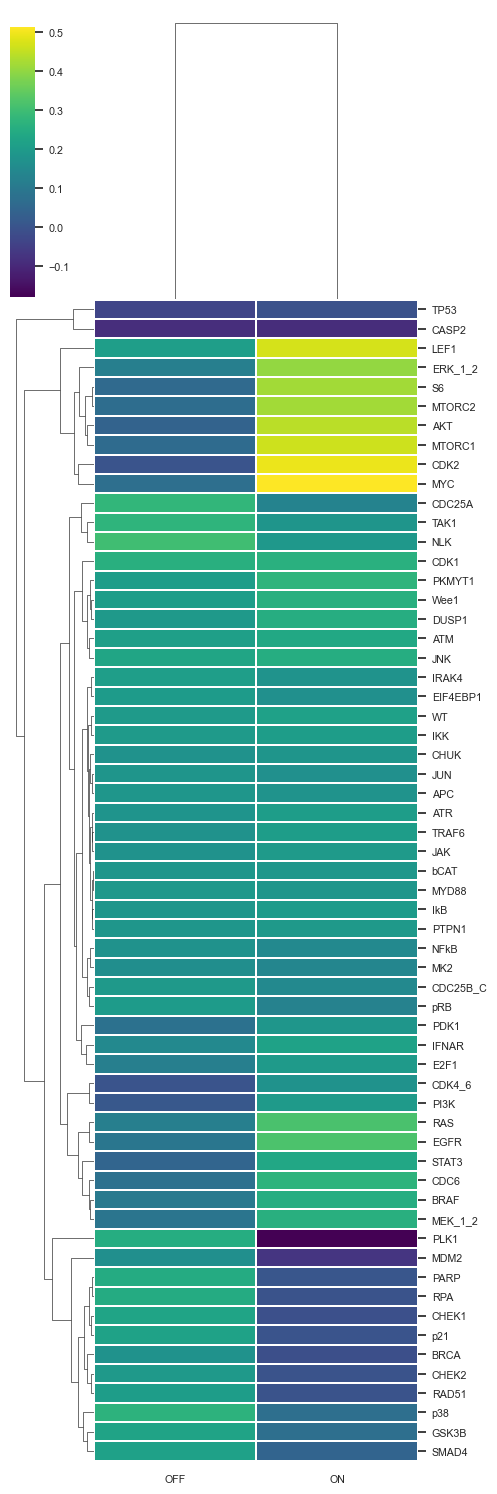

In [70]:
import seaborn as sns
sns.set(font_scale=0.7)
sns.clustermap(compared_activity.transpose(),
               cmap = 'viridis',
               figsize = (5,15), 
               linewidths=0.2)

In [38]:
sensitivity = sensitivity.replace(np.nan,0)
cheki = cheki.replace(np.nan,0)
sensitivity_compare = pd.DataFrame([(sensitivity.Apoptosis-sensitivity.Proliferation),cheki.Apoptosis-cheki.Proliferation],
                                   index = ['Untreated','Treated'])

In [53]:
test = sensitivity_compare.loc['Treated',:] - sensitivity_compare.loc['Untreated',:]
test.sort_values()

CASP2      -0.078492
TP53       -0.038754
CDK2        0.000000
CDK4_6      0.000000
PI3K        0.012027
MYC         0.049726
CDC6        0.060533
STAT3       0.062607
AKT         0.064187
S6          0.069954
MTORC2      0.071224
BRAF        0.083699
MTORC1      0.087819
PDK1        0.090432
ERK_1_2     0.091747
MEK_1_2     0.096697
EGFR        0.104161
RAS         0.111092
MK2         0.132290
CHEK2       0.150394
JUN         0.153388
E2F1        0.154192
p21         0.156648
ATM         0.160497
NFkB        0.160534
IFNAR       0.160898
IkB         0.164540
BRCA        0.168826
MDM2        0.168896
APC         0.172667
ATR         0.173268
Wee1        0.175340
IKK         0.180094
RAD51       0.180111
bCAT        0.182000
PLK1        0.184336
EIF4EBP1    0.185015
MYD88       0.188438
pRB         0.189816
IRAK4       0.190205
LEF1        0.191228
CHUK        0.192178
CDC25B_C    0.196387
DUSP1       0.197435
SMAD4       0.197663
TRAF6       0.198038
PKMYT1      0.200227
GSK3B       0

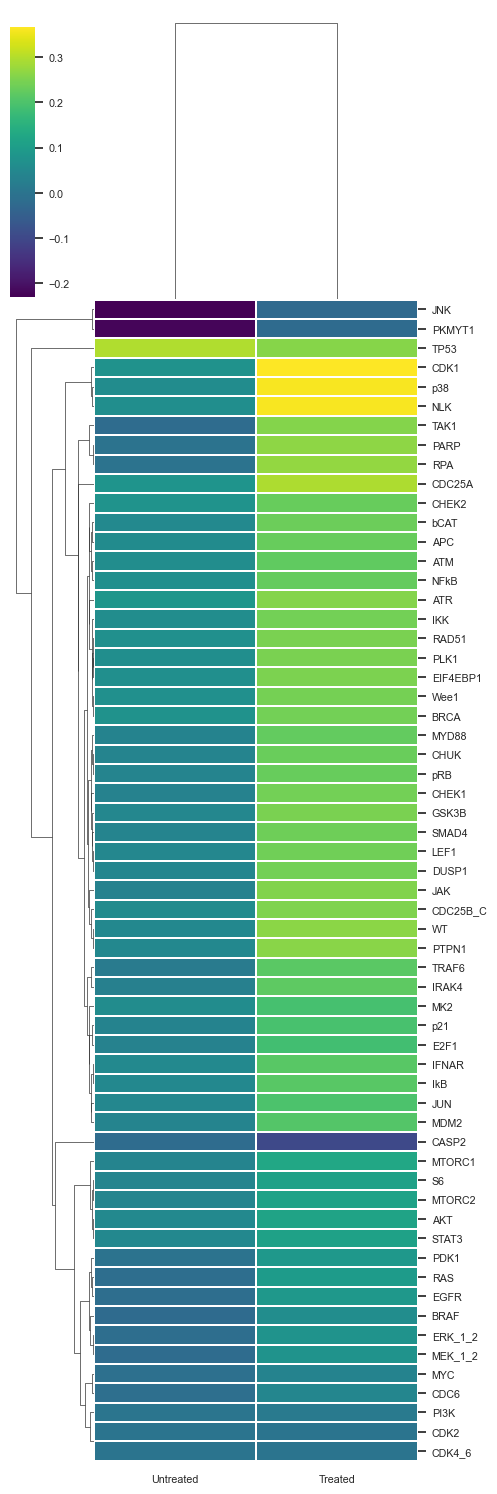

In [49]:
import seaborn as sns
sns.set(font_scale=0.7)
sns.clustermap(sensitivity_compare.transpose(),
               cmap = 'viridis',
               figsize = (5,15), 
               linewidths=0.2)

In [3]:
# Setup the name of the files
model_name =  'CRC_model_20230824'

def get_model(model_name):
    ## Set up the required files
    bnd_file = model_name+".bnd"
    cfg_WT = model_name+".bnd.cfg"

    ## Load MaBoSS model
    WT = maboss.load(bnd_file, cfg_WT)

    ## modify the max_time if necessary
    ## select the variables considered to be internal (not appearing in the resulting csv file) 
    ## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
    WT_allinputs.update_parameters(sample_count = 1000)
    WT_allinputs.update_parameters(thread_count = 10)

    ## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
    ## If the model is big, the computations may take a very long time.
    ## We advise to set as external, only the variables that are relevant for the analysis

    ## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
    #for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
    for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
        WT_allinputs.network[name].is_internal = True

    ## Put all inputs at random
    for i in WT_allinputs.network.names:
        WT_allinputs.network.set_istate(i,[0.5,0.5])

    ## Set all inputs at 0.5
    WT_allinputs.network.set_istate('EGF',[0.5,0.5])
    WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
    WT_allinputs.network.set_istate('TNF',[0.5,0.5])
    WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
    WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
    WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
    WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])

    ####WT_allinputs.network.set_istate('GSK3B',[1,0])## Set up the required files
    bnd_file = model_name+".bnd"
    cfg_WT = model_name+".bnd.cfg"

    ## Load MaBoSS model
    WT = maboss.load(bnd_file, cfg_WT)

    ## modify the max_time if necessary
    ## select the variables considered to be internal (not appearing in the resulting csv file) 
    ## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

    WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
    WT_allinputs.update_parameters(sample_count = 1000)
    WT_allinputs.update_parameters(thread_count = 10)

    ## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
    ## If the model is big, the computations may take a very long time.
    ## We advise to set as external, only the variables that are relevant for the analysis

    ## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
    #for name in "ERK_1_2 MK2 p38 Wee1 BRAF CDK1 p21 TP53 Proliferation Senescence Apoptosis".split(' '):
    for name in "TAK1 PI3K MTORC2 CDC25A CDK4_6 S6 JNK AKT p38 p21".split(' '):
        WT_allinputs.network[name].is_internal = True

    ## Put all inputs at random
    for i in WT_allinputs.network.names:
        WT_allinputs.network.set_istate(i,[0.5,0.5])

    ## Set all inputs at 0.5
    WT_allinputs.network.set_istate('EGF',[0.5,0.5])
    WT_allinputs.network.set_istate('TGFb',[0.5,0.5])
    WT_allinputs.network.set_istate('TNF',[0.5,0.5])
    WT_allinputs.network.set_istate('Wnt',[0.5,0.5])
    WT_allinputs.network.set_istate('IL1R1',[0.5,0.5])
    WT_allinputs.network.set_istate('IFNA',[0.5,0.5])
    WT_allinputs.network.set_istate('DNA_damage_agent',[1,0])

    ####WT_allinputs.network.set_istate('GSK3B',[1,0])
    
    return(WT_allinputs)